# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
from backtesting import Strategy

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


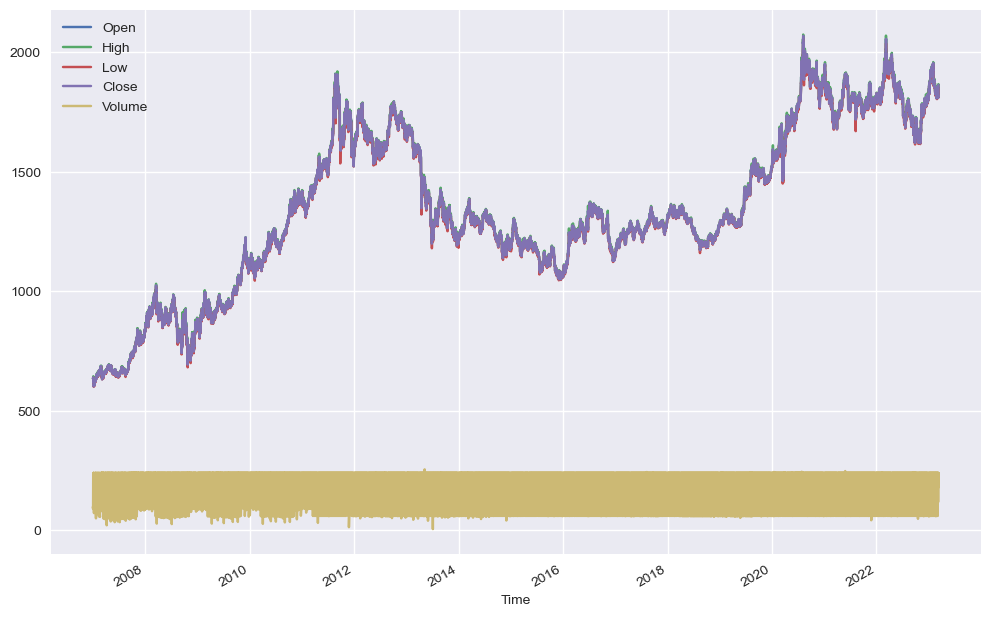

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
strategy = Linear_Regression
account_size = 1000
folder_ML_Strategy = 'Linear Regression'

In [299]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.account_size = account_size

    def Prepare(self, lags=1):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=1):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=self.account_size , margin= 1/100)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        self.Predict()
        result_test = self.Backtest(self.data_test)
       

        return result_train, result_test

## TF D1

In [12]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'


In [301]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [302]:
train , test = ml.Run()

### In-Sample Backtesting

In [303]:
train

Start                     2007-01-03 00:00:00
End                       2020-12-30 00:00:00
Duration                   5110 days 00:00:00
Exposure Time [%]                   99.954139
Equity Final [$]                      2691.52
Equity Peak [$]                      2914.652
Return [%]                            169.152
Buy & Hold Return [%]              202.421314
Return (Ann.) [%]                    5.888153
Volatility (Ann.) [%]               10.690028
Sharpe Ratio                         0.550808
Sortino Ratio                        0.844498
Calmar Ratio                         0.187534
Max. Drawdown [%]                  -31.397759
Avg. Drawdown [%]                   -1.973865
Max. Drawdown Duration     2638 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                  342
Win Rate [%]                        51.169591
Best Trade [%]                      27.434382
Worst Trade [%]                     -9.384876
Avg. Trade [%]                    

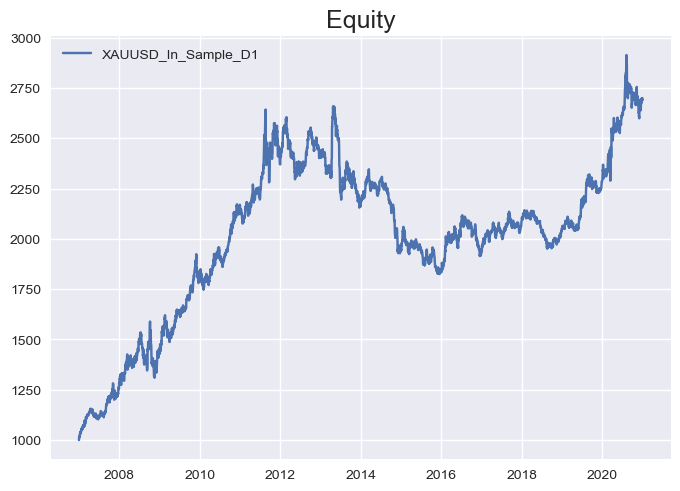

In [304]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [305]:
test

Start                     2020-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   1162 days 00:00:00
Exposure Time [%]                   99.797776
Equity Final [$]                     1204.337
Equity Peak [$]                      1571.025
Return [%]                            20.4337
Buy & Hold Return [%]               20.146953
Return (Ann.) [%]                    4.851543
Volatility (Ann.) [%]               22.565702
Sharpe Ratio                         0.214996
Sortino Ratio                        0.318019
Calmar Ratio                          0.13866
Max. Drawdown [%]                  -34.988749
Avg. Drawdown [%]                   -5.685562
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                   77
Win Rate [%]                         40.25974
Best Trade [%]                      19.880736
Worst Trade [%]                      -5.95332
Avg. Trade [%]                    

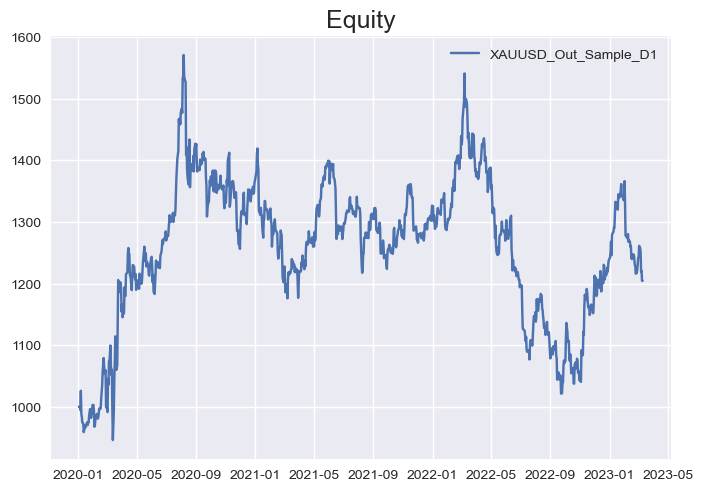

In [306]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [307]:
filename_train = f'result_{TF}_In_Sample.csv'

In [308]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [309]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [310]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [311]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'


In [312]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [313]:
train , test = ml.Run()

### In-Sample Backtesting

In [314]:
train

Start                     2007-01-01 08:00:00
End                       2020-12-31 16:00:00
Duration                   5113 days 08:00:00
Exposure Time [%]                     99.9911
Equity Final [$]                     2197.336
Equity Peak [$]                      2352.435
Return [%]                           119.7336
Buy & Hold Return [%]              198.232056
Return (Ann.) [%]                     4.65063
Volatility (Ann.) [%]               13.822976
Sharpe Ratio                         0.336442
Sortino Ratio                        0.498407
Calmar Ratio                         0.114203
Max. Drawdown [%]                   -40.72236
Avg. Drawdown [%]                   -1.376776
Max. Drawdown Duration     3262 days 00:00:00
Avg. Drawdown Duration       26 days 01:00:00
# Trades                                 3403
Win Rate [%]                        55.598002
Best Trade [%]                      10.756678
Worst Trade [%]                    -11.637831
Avg. Trade [%]                    

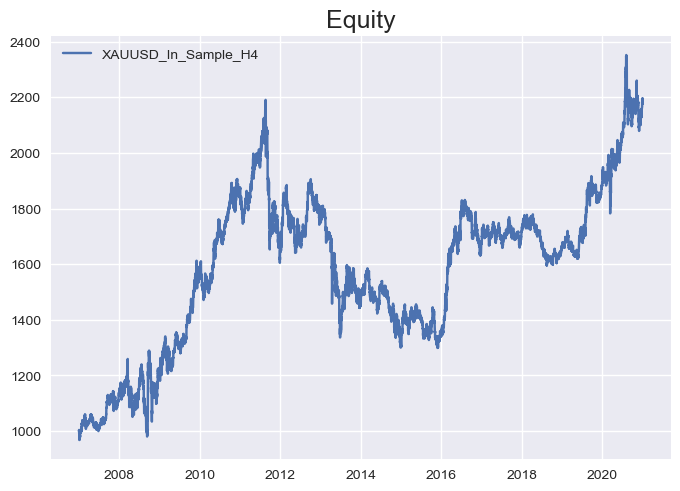

In [315]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [316]:
test

Start                     2020-01-02 04:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.960807
Equity Final [$]                     1475.331
Equity Peak [$]                      1671.704
Return [%]                            47.5331
Buy & Hold Return [%]               22.708422
Return (Ann.) [%]                   10.328657
Volatility (Ann.) [%]                23.72955
Sharpe Ratio                         0.435266
Sortino Ratio                        0.681087
Calmar Ratio                         0.313083
Max. Drawdown [%]                  -32.990111
Avg. Drawdown [%]                   -2.788414
Max. Drawdown Duration      557 days 16:00:00
Avg. Drawdown Duration       23 days 02:00:00
# Trades                                  701
Win Rate [%]                        56.348074
Best Trade [%]                       4.035329
Worst Trade [%]                      -6.08057
Avg. Trade [%]                    

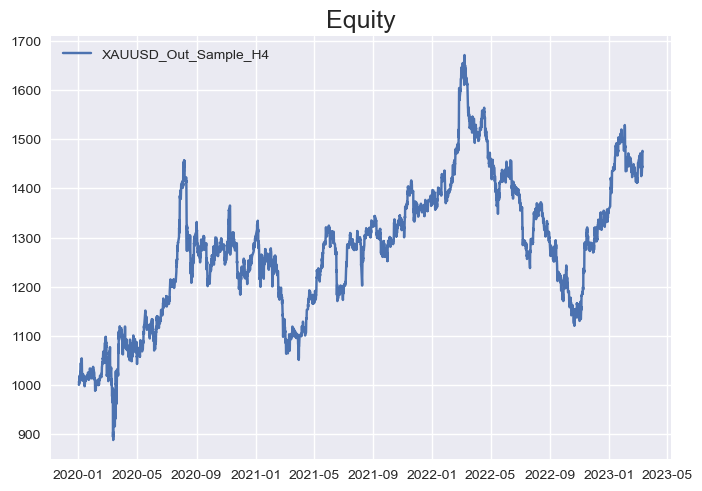

In [317]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [318]:
filename_train = f'result_{TF}_In_Sample.csv'

In [319]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [320]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [321]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [322]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'


In [323]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [324]:
train , test = ml.Run()

### In-Sample Backtesting

In [325]:
train

Start                     2007-01-01 02:00:00
End                       2020-12-31 20:00:00
Duration                   5113 days 18:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                      2061.86
Equity Peak [$]                      2259.232
Return [%]                            106.186
Buy & Hold Return [%]              198.784918
Return (Ann.) [%]                    4.263365
Volatility (Ann.) [%]               13.326803
Sharpe Ratio                         0.319909
Sortino Ratio                        0.464372
Calmar Ratio                         0.097166
Max. Drawdown [%]                  -43.876927
Avg. Drawdown [%]                   -0.812661
Max. Drawdown Duration     3271 days 14:00:00
Avg. Drawdown Duration       14 days 13:00:00
# Trades                                  847
Win Rate [%]                        55.253837
Best Trade [%]                       8.931652
Worst Trade [%]                    -14.152369
Avg. Trade [%]                    

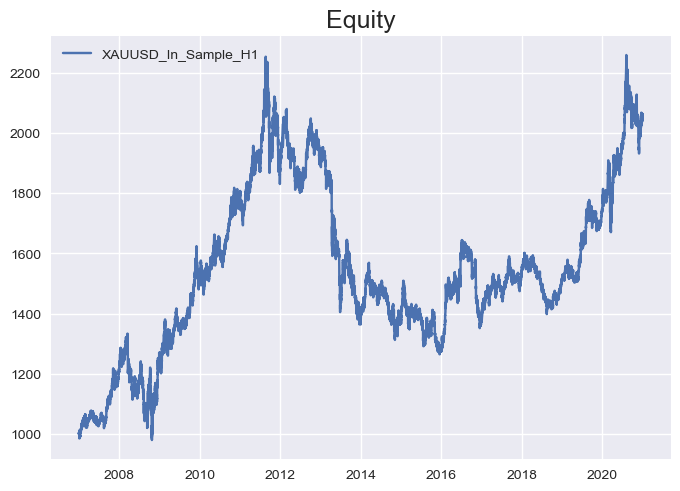

In [326]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [327]:
test

Start                     2020-01-02 01:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.989396
Equity Final [$]                     1225.634
Equity Peak [$]                      1513.321
Return [%]                            22.5634
Buy & Hold Return [%]               22.689281
Return (Ann.) [%]                    5.097408
Volatility (Ann.) [%]                23.20857
Sharpe Ratio                         0.219635
Sortino Ratio                        0.320905
Calmar Ratio                          0.13593
Max. Drawdown [%]                  -37.500306
Avg. Drawdown [%]                   -1.500998
Max. Drawdown Duration      945 days 19:00:00
Avg. Drawdown Duration       15 days 01:00:00
# Trades                                  133
Win Rate [%]                         48.87218
Best Trade [%]                       7.718786
Worst Trade [%]                     -7.845773
Avg. Trade [%]                    

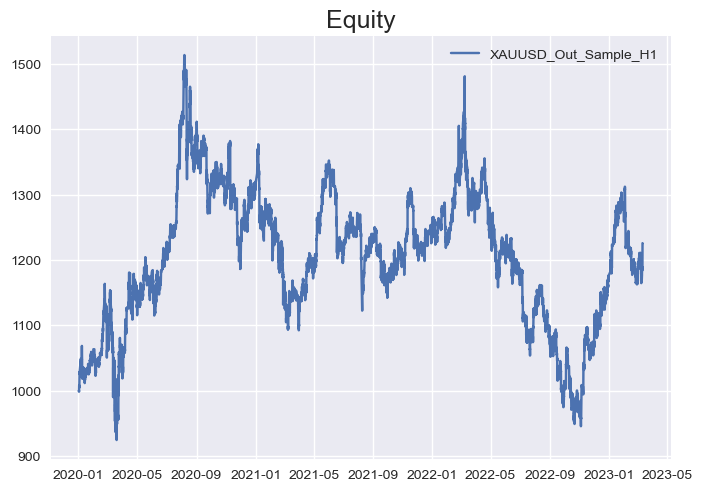

In [328]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [329]:
filename_train = f'result_{TF}_In_Sample.csv'

In [330]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [331]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [332]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [333]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'


In [334]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [335]:
train , test = ml.Run()

### In-Sample Backtesting

In [336]:
train

Start                     2007-01-01 01:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 20:00:00
Exposure Time [%]                   99.998819
Equity Final [$]                     2637.293
Equity Peak [$]                      2707.906
Return [%]                           163.7293
Buy & Hold Return [%]              198.526044
Return (Ann.) [%]                    5.756149
Volatility (Ann.) [%]                11.86435
Sharpe Ratio                         0.485163
Sortino Ratio                        0.726981
Calmar Ratio                         0.155014
Max. Drawdown [%]                  -37.133066
Avg. Drawdown [%]                   -0.622943
Max. Drawdown Duration     3244 days 03:00:00
Avg. Drawdown Duration        9 days 12:07:00
# Trades                                 4805
Win Rate [%]                        44.557752
Best Trade [%]                      11.097933
Worst Trade [%]                     -5.209359
Avg. Trade [%]                    

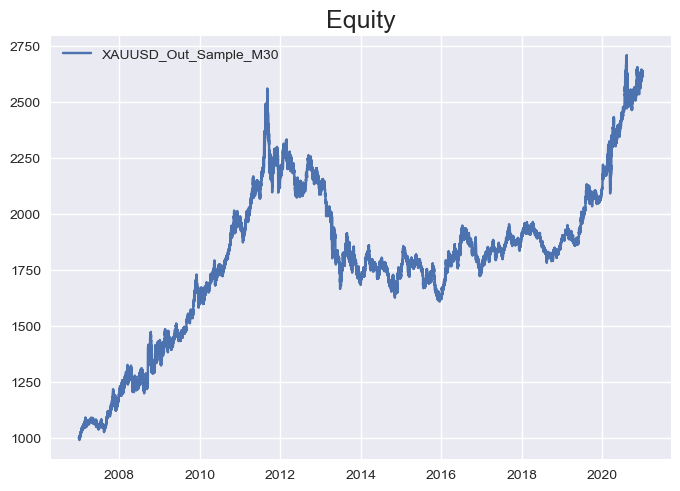

In [337]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [338]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 17:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1424.607
Equity Peak [$]                      1602.809
Return [%]                            42.4607
Buy & Hold Return [%]               22.702203
Return (Ann.) [%]                    9.146279
Volatility (Ann.) [%]               22.072216
Sharpe Ratio                          0.41438
Sortino Ratio                        0.630519
Calmar Ratio                         0.321405
Max. Drawdown [%]                  -28.457165
Avg. Drawdown [%]                   -1.269751
Max. Drawdown Duration      575 days 01:30:00
Avg. Drawdown Duration        9 days 21:43:00
# Trades                                  823
Win Rate [%]                        45.443499
Best Trade [%]                        8.50203
Worst Trade [%]                     -3.165892
Avg. Trade [%]                    

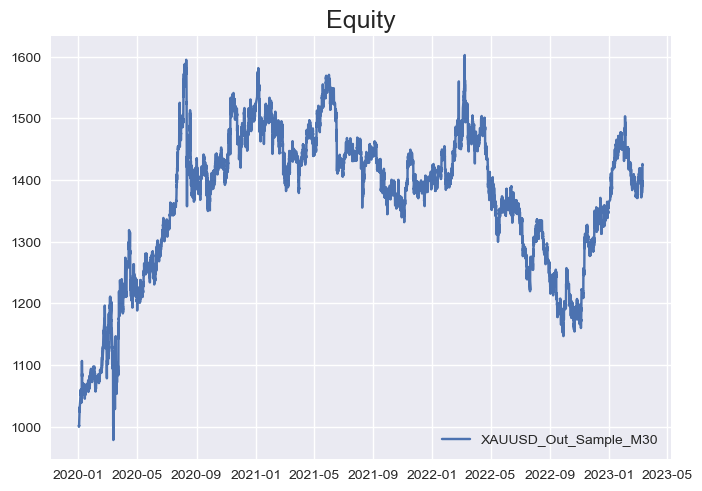

In [339]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [340]:
filename_train = f'result_{TF}_In_Sample.csv'

In [341]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [342]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [343]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [344]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'


In [345]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [346]:
train , test = ml.Run()

### In-Sample Backtesting

In [347]:
train

Start                     2014-09-23 13:30:00
End                       2020-12-31 21:30:00
Duration                   2291 days 08:00:00
Exposure Time [%]                   99.998651
Equity Final [$]                     1583.872
Equity Peak [$]                      1721.961
Return [%]                            58.3872
Buy & Hold Return [%]               54.896138
Return (Ann.) [%]                    6.108749
Volatility (Ann.) [%]               17.195975
Sharpe Ratio                         0.355243
Sortino Ratio                        0.543735
Calmar Ratio                          0.17866
Max. Drawdown [%]                  -34.192029
Avg. Drawdown [%]                   -0.748221
Max. Drawdown Duration     1360 days 02:45:00
Avg. Drawdown Duration        7 days 07:28:00
# Trades                                35519
Win Rate [%]                        54.080914
Best Trade [%]                       2.056397
Worst Trade [%]                     -3.263558
Avg. Trade [%]                    

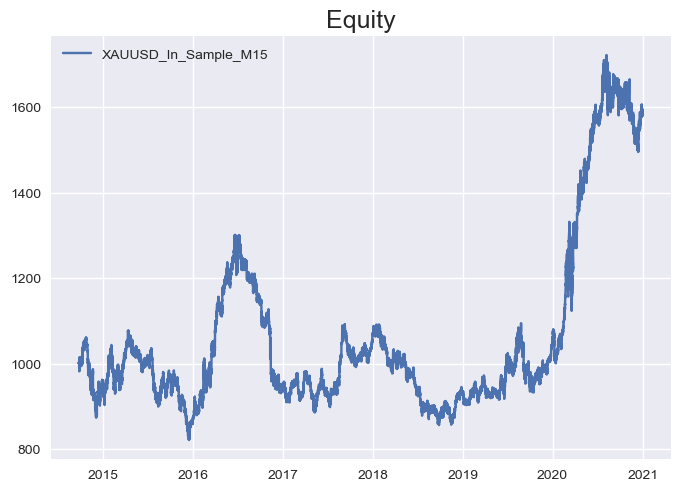

In [348]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [349]:
test

Start                     2020-01-01 23:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     1372.403
Equity Peak [$]                      1663.744
Return [%]                            37.2403
Buy & Hold Return [%]               22.692269
Return (Ann.) [%]                    8.382713
Volatility (Ann.) [%]               21.248468
Sharpe Ratio                         0.394509
Sortino Ratio                        0.606229
Calmar Ratio                         0.293819
Max. Drawdown [%]                  -28.530171
Avg. Drawdown [%]                   -0.673145
Max. Drawdown Duration      945 days 09:15:00
Avg. Drawdown Duration        4 days 15:18:00
# Trades                                22042
Win Rate [%]                        53.869885
Best Trade [%]                       2.056397
Worst Trade [%]                     -3.462848
Avg. Trade [%]                    

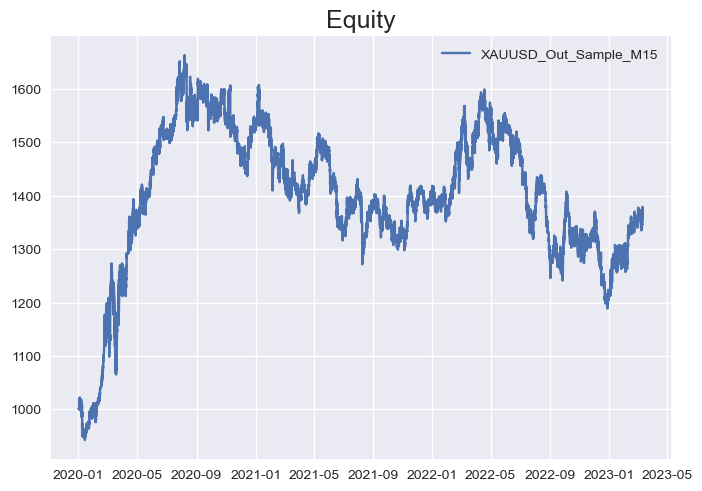

In [350]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [351]:
filename_train = f'result_{TF}_In_Sample.csv'

In [352]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [353]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [354]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [355]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'


In [356]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [357]:
train , test = ml.Run()

### In-Sample Backtesting

In [358]:
train

Start                     2020-05-15 11:20:00
End                       2023-03-10 17:50:00
Duration                   1029 days 06:30:00
Exposure Time [%]                      99.999
Equity Final [$]                      300.817
Equity Peak [$]                      1029.487
Return [%]                           -69.9183
Buy & Hold Return [%]                7.497414
Return (Ann.) [%]                  -29.651342
Volatility (Ann.) [%]               32.232403
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -74.02075
Avg. Drawdown [%]                   -6.861685
Max. Drawdown Duration     1029 days 01:55:00
Avg. Drawdown Duration       93 days 13:35:00
# Trades                               100123
Win Rate [%]                        47.461622
Best Trade [%]                       3.754972
Worst Trade [%]                     -1.030794
Avg. Trade [%]                    

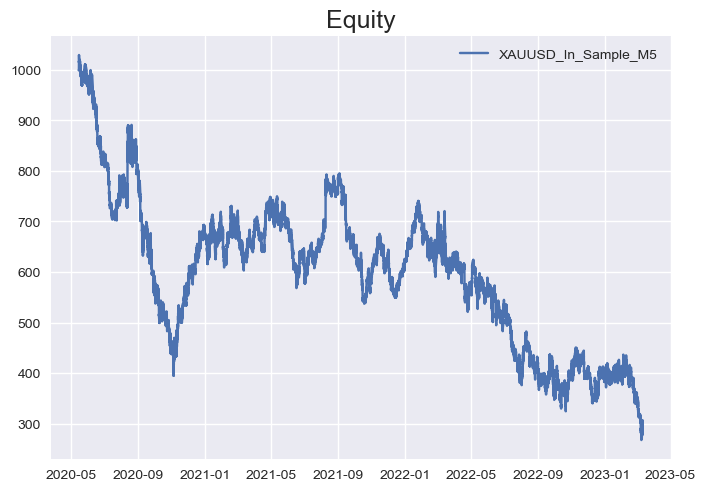

In [359]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [360]:
test

Start                     2023-01-02 23:10:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:45:00
Exposure Time [%]                   99.985068
Equity Final [$]                       921.47
Equity Peak [$]                      1056.425
Return [%]                             -7.853
Buy & Hold Return [%]                2.074288
Return (Ann.) [%]                  -28.798133
Volatility (Ann.) [%]                14.45804
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.998769
Avg. Drawdown [%]                   -1.377195
Max. Drawdown Duration       35 days 04:10:00
Avg. Drawdown Duration        2 days 16:01:00
# Trades                                 6703
Win Rate [%]                        46.725347
Best Trade [%]                       1.464118
Worst Trade [%]                     -0.412583
Avg. Trade [%]                    

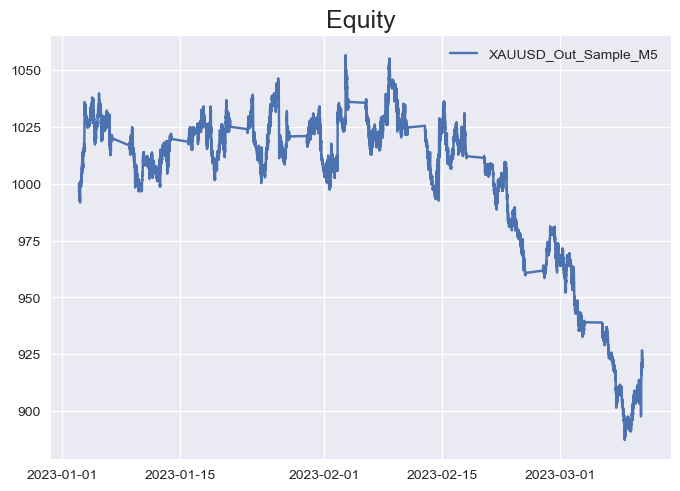

In [361]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [362]:
filename_train = f'result_{TF}_In_Sample.csv'

In [363]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [364]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [365]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [366]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'


In [367]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [368]:
train , test = ml.Run()

### In-Sample Backtesting

In [369]:
train

Start                     2022-08-16 23:15:00
End                       2023-03-10 17:58:00
Duration                    205 days 18:43:00
Exposure Time [%]                      99.999
Equity Final [$]                     1614.067
Equity Peak [$]                      1630.402
Return [%]                            61.4067
Buy & Hold Return [%]                4.981702
Return (Ann.) [%]                   98.187222
Volatility (Ann.) [%]               40.972668
Sharpe Ratio                         2.396408
Sortino Ratio                        8.291519
Calmar Ratio                         9.941256
Max. Drawdown [%]                   -9.876742
Avg. Drawdown [%]                   -0.178263
Max. Drawdown Duration       48 days 22:24:00
Avg. Drawdown Duration        0 days 05:25:00
# Trades                                99908
Win Rate [%]                        52.190015
Best Trade [%]                       0.988492
Worst Trade [%]                     -0.788444
Avg. Trade [%]                    

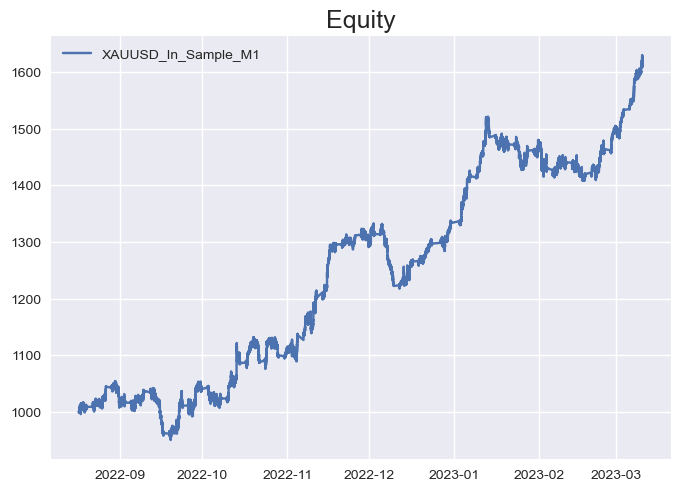

In [370]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [371]:
test

Start                     2023-01-02 23:02:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:57:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1277.062
Equity Peak [$]                      1292.714
Return [%]                            27.7062
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  189.498646
Volatility (Ann.) [%]               69.127715
Sharpe Ratio                         2.741283
Sortino Ratio                        14.14933
Calmar Ratio                        19.767824
Max. Drawdown [%]                   -9.586217
Avg. Drawdown [%]                   -0.159297
Max. Drawdown Duration       48 days 22:24:00
Avg. Drawdown Duration        0 days 03:55:00
# Trades                                33504
Win Rate [%]                        52.748926
Best Trade [%]                       0.673684
Worst Trade [%]                     -0.644081
Avg. Trade [%]                    

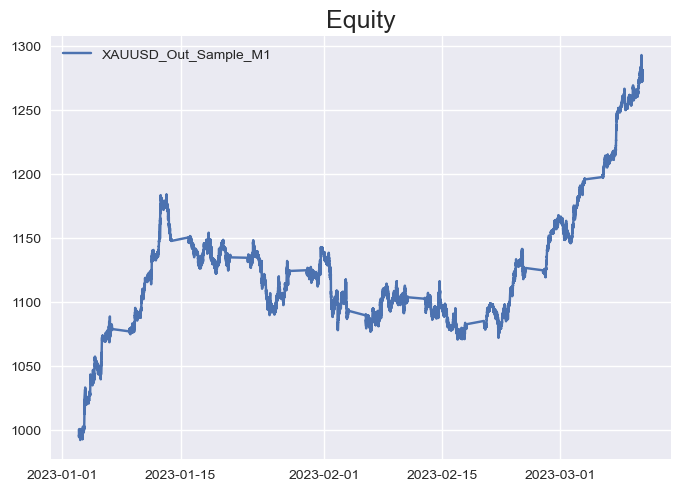

In [372]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [373]:
filename_train = f'result_{TF}_In_Sample.csv'

In [374]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')